In [ ]:
# default_exp data.datasets

In [ ]:
from nbdev.export import *

## Factory Method for Loading the Cassava Dataset

In [ ]:
# export
import os

import cv2
import pandas as pd
import torch
from fastcore.all import delegates, ifnone, store_attr
from PIL import Image
from torch.utils.data import Dataset

from src import _logger
from src.core import idx2lbl

In [ ]:
# export
def load_data(pth: str, im_dir: str, curr_fold: int = 0, shuffle: bool = True) -> pd.DataFrame:
    "loads the dataframe and formats it"
    assert curr_fold < 5

    data = pd.read_csv(pth)

    data["filePath"] = [os.path.join(im_dir, data["image_id"][idx]) for idx in range(len(data))]
    data["is_valid"] = [data.kfold[n] == curr_fold for n in range(len(data))]

    if shuffle:
        data = data.sample(frac=1).reset_index(drop=True, inplace=False)
    else:
        data = data.reset_index(drop=True, inplace=False)

    return data

In [ ]:
csv_path = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
imgs_dir = "../../Datasets/cassava/train_images/"

df = load_data(csv_path, imgs_dir, curr_fold=0, shuffle=True)
df.head()

,image_id,label,filePath,kfold,is_valid
0,186394398.jpg,0,../../Datasets/cassava/train_images/186394398.jpg,1,False
1,2806814131.jpg,3,../../Datasets/cassava/train_images/2806814131...,1,False
2,4158544304.jpg,3,../../Datasets/cassava/train_images/4158544304...,3,False
3,608792631.jpg,3,../../Datasets/cassava/train_images/608792631.jpg,4,False
4,22667751.jpg,2,../../Datasets/cassava/train_images/22667751.jpg,4,False


In [ ]:
# export
def pil_loader(path):
    "loads an image using PIL, mainly used for torchvision transformations"
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")
    
def cv2_loader(path):
    "loads an image using cv2, mainly used for albumentations transformations"
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
# export
class CassavaDataset(Dataset):
    "Create `CassavaDataset` rom `df` using `fn_col`"

    def __init__(self, df, fn_col, label_col=None, transform=None, train: bool = True, backend="torchvision"):
        store_attr("df, fn_col, label_col, transform, train, backend")
        self.df = df.copy()
        self._setup_loader()
        
    def _setup_loader(self):
        if self.backend == "torchvision":
            self.loader = pil_loader
        elif self.backend == "albumentations":
            self.loader = cv2_loader

    def reload_transforms(self, transform, backend=None):
        "change the transformations used after `__init__`"
        self.backend = ifnone(backend, self.backend)
        self._setup_loader()
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_id = self.df[self.fn_col][index]
        # load the image
        image = self.loader(image_id)

        # apply transformations
        if self.backend == "torchvision":
            image = self.transform(image)
        elif self.backend == "albumentations":
            image = self.transform(image=image)
        
        # returns image-tensors and Optionally target-tensors
        if self.train:
            target = self.df[self.label_col][index]
            target = torch.tensor(target)
            return image, target
        else:
            return image

    @classmethod
    @delegates(__init__)
    def from_albu_tfms(cls, df, fn_col, backend="albumentations", **kwargs):
        "Create `Dataset` from `df` using `albumentations` transformations and `cv2`"
        return cls(df, fn_col, backend=backend, **kwargs)

    @classmethod
    @delegates(__init__)
    def from_torchvision_tfms(cls, df, fn_col, backend="torchvision", **kwargs):
        "Create `Dataset` from `df` using `torchvision` transformations and `PIL`"
        return cls(df, fn_col, backend=backend, **kwargs)

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from hydra.utils import instantiate
from omegaconf import OmegaConf
from timm.data.constants import IMAGENET_DEFAULT_MEAN as mean
from timm.data.constants import IMAGENET_DEFAULT_STD as std
from timm.data.transforms import RandomResizedCropAndInterpolation
from torchvision.utils import make_grid

In [ ]:
t1 = T.Compose([
    RandomResizedCropAndInterpolation(512, interpolation="random"), 
    T.ToTensor(), 
    T.Normalize(mean, std)])

t2 = T.Compose([
    RandomResizedCropAndInterpolation(512, interpolation="random"), 
    T.ToTensor(), 
    T.ColorJitter(0.1, 0.1, 0.1),
    T.Normalize(mean, std),
    T.RandomErasing(),])

dset = CassavaDataset.from_torchvision_tfms(df, "filePath", label_col="label", transform=t1)

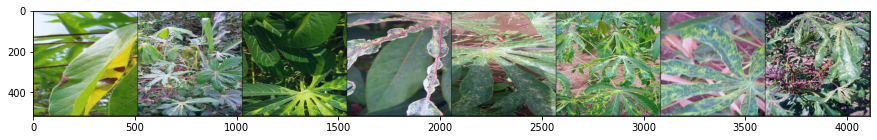

In [ ]:
image, label = next(iter(torch.utils.data.DataLoader(dset, batch_size=8)))
grid = make_grid(image, normalize=True).permute(1, 2, 0).numpy()

plt.figure(figsize=(15, 10))
plt.imshow(grid)

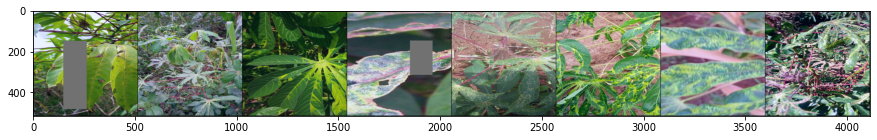

In [ ]:
dset.reload_transforms(transform=t2)
image, label = next(iter(torch.utils.data.DataLoader(dset, batch_size=8)))
grid = make_grid(image, normalize=True).permute(1, 2, 0).numpy()

plt.figure(figsize=(15, 10))
plt.imshow(grid)

In [ ]:
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.datasets.ipynb.
Converted 01a_data.mixmethods.ipynb.
Converted 02_losses.ipynb.
Converted 03_layers.ipynb.
Converted 03a_networks.ipynb.
Converted 04_optimizers.ipynb.
Converted 04a_schedulers.ipynb.
Converted 05_lightning.data.ipynb.
Converted 05a_lightning.core.ipynb.
Converted 05b_lightning.callbacks.ipynb.
Converted 06_fastai.core.ipynb.
Converted index.ipynb.
